In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, t

#second version

sns.set(style="whitegrid", font_scale=1.1)

df_species = pd.read_csv("data/processed/species.csv")
df_sites = pd.read_csv("data/processed/sites.csv")
df_observations = pd.read_csv("data/processed/observations.csv")

/tmp/ipykernel_18768/2518284138.py:15: DtypeWarning: Columns (12,13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_observations = pd.read_csv("data/processed/observations.csv")


In this markdown, we will study the evolution of population for given species of birds, and calculate Confidence Intervals.


In [2]:
# Let's get interested by the evolutions of species
species = df_observations["clean_espece"].unique()
evolutionSpecies = {name : pd.Series() for name in species}


for specie in species:

    df_cut = df_observations[df_observations["clean_espece"] == specie]
    evolution = df_cut.groupby("year")["Amount"].sum()

    if 2014 in evolution.keys():
        evolution = evolution.drop(2014)

    evolutionSpecies[specie] = evolution

evolutionSpecies = pd.Series(evolutionSpecies)

In [3]:
# Let's identify the species wich are decreasing the most

changeSpecies = pd.Series(index = species)

length = 2025 - 2014 + 1

for specie in species:

    evol = evolutionSpecies[specie]

    lastInd = len(evol) - 1
    if lastInd > -1 and evol.iat[0] != 0.0:
        changeSpecies[specie] = 100*(evol.iat[lastInd] - evol.iat[0]) / evol.iat[0]




In the cells above, we created two variables that we are gonna use for the rest of the file :

- ```evolution_species``` which store for each specie their population each year
- ```evolution_change``` wich store the increase (or decrease) between the first year and the last year

We deleted the year 2014 because, as the observations began in the middle of the year, and thus the number of observations for this year 
is way too low compared to others, and will give wrong informations for the population.

Now, we are going to identify two species :

- The specie who had the biggest decrease of their population.
- The specie who had the biggest increase of their population.

Also we defined a threshold, considering only species who had been observed 220 times the first year.

In [13]:

seuil = 220

minEsp, maxEsp = None, None
minChange, maxChange = np.inf, -np.inf 

for specie in species:
    evol = evolutionSpecies[specie]
    rateChange = changeSpecies[specie]

    if len(evol) > 0 and not(pd.isna(rateChange)) and evol.iat[0] > seuil :

        if rateChange < minChange:
            minChange = rateChange
            minEsp = specie

        if rateChange > maxChange:
            maxChange = rateChange
            maxEsp = specie

maxEvol = evolutionSpecies[maxEsp]

popBegin = maxEvol.iat[0]
popEnd = maxEvol.iat[len(maxEvol) - 1]
change = changeSpecies[maxEsp]

print(f"The specie of bird that had the biggest increase of its population between 2015 and 2025 is the {maxEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, increasing by {change:.2f} %.")
print("---------------------------------------------------------------------------------------------")


minEvol = evolutionSpecies[minEsp]

popBegin = minEvol.iat[0]
popEnd = minEvol.iat[len(minEvol) - 1]
change = changeSpecies[minEsp]

print(f"The specie of bird that had the biggest decrease of its population between 2015 and 2025 is the {minEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, decreasing by {np.abs(change):.2f} %.")
print("---------------------------------------------------------------------------------------------")
years = maxEvol.keys()


The specie of bird that had the biggest increase of its population between 2015 and 2025 is the tourterelle turque
They went from a population of 329.0 in 2015 to 885.0, increasing by 169.00 %.
---------------------------------------------------------------------------------------------
The specie of bird that had the biggest decrease of its population between 2015 and 2025 is the colibri falle-vert
They went from a population of 226.0 in 2015 to 105.0, decreasing by 53.54 %.
---------------------------------------------------------------------------------------------


We have identified two species : 
- The `colibri falle-vert` is the specie with the biggest decrease of population (-53.54%).
- The `tourterelle turque` is the specie with the biggest increase of population (+169%).

Now we are going to plot these datas on a graph, calculate a linear model to help predict the amount of observations for the next years.
We ar also going to calculated the Confidence Interval for the model.

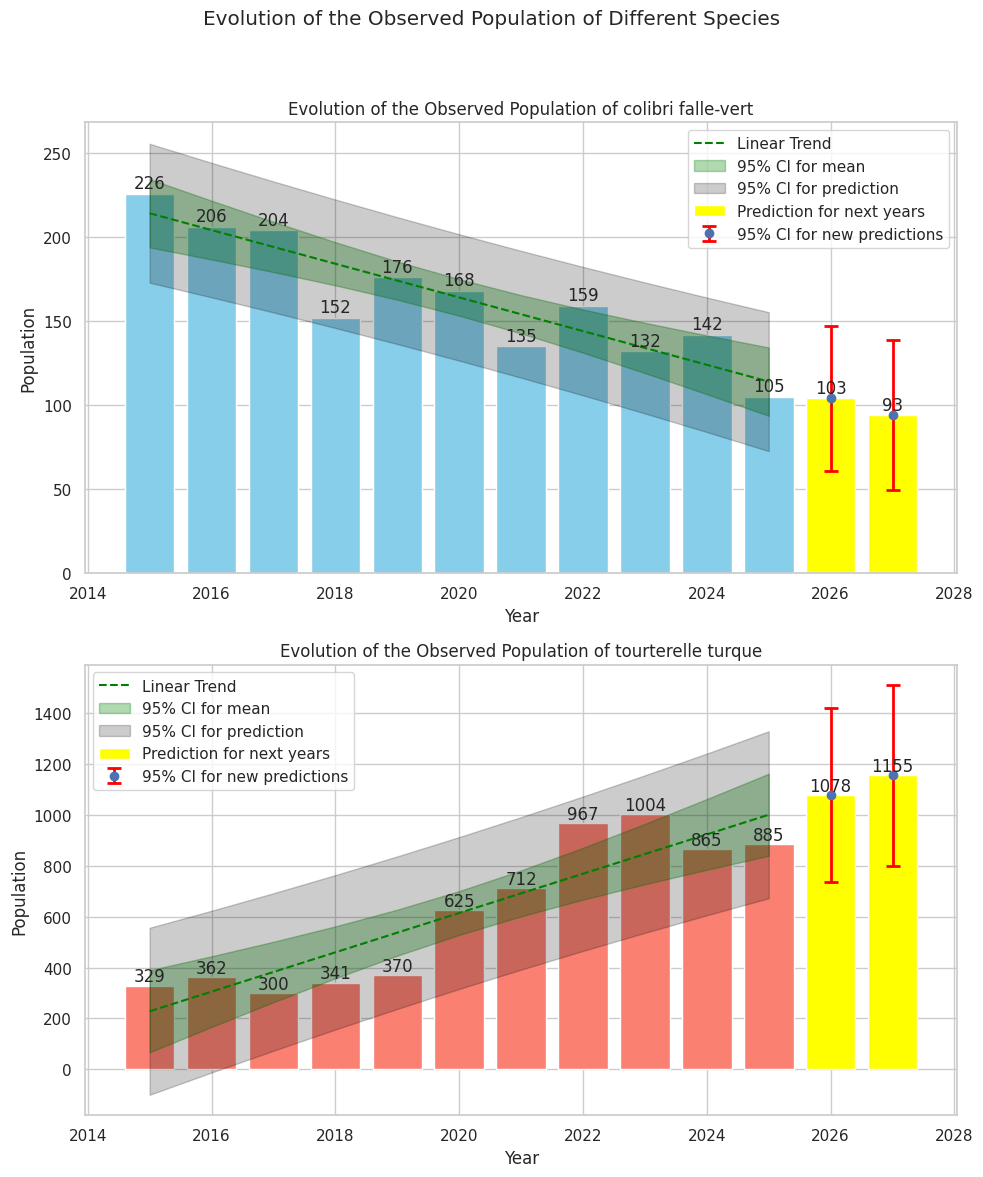

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

def ci_linear_model(x, Y_real, Y_model, alpha=0.05):
    n = len(x)
    x_mean = np.mean(x)
    
    # Residuals and variance estimates
    residues = Y_real - Y_model
    SSE = np.sum(np.square(residues))
    MSE = SSE / (n - 2)
    Sxx = np.sum(np.square(x - x_mean))

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, n - 2)

    SE_mean = np.sqrt(MSE * (1/n + (x - x_mean)**2 / Sxx))
    SE_pred = np.sqrt(MSE * (1 + 1/n + (x - x_mean)**2 / Sxx))

    return t_crit * SE_mean, t_crit * SE_pred

def compute_ci_for_new_data(x_train, Y_real, Y_model, x_new, alpha=0.05):

    n = len(x_train)
    x_mean = np.mean(x_train)
    
    # Residuals and variance estimates from training data
    residues = Y_real - Y_model
    SSE = np.sum(np.square(residues))
    MSE = SSE / (n - 2)
    Sxx = np.sum(np.square(x_train - x_mean))

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, n - 2)

    # CI for new data points
    SE_mean_new = np.sqrt(MSE * (1/n + (x_new - x_mean)**2 / Sxx))
    SE_pred_new = np.sqrt(MSE * (1 + 1/n + (x_new - x_mean)**2 / Sxx))

    return t_crit * SE_mean_new, t_crit * SE_pred_new


def plot_with_trend(ax, x, y, color, title):
    # Bar plot
    ax.bar(x, y, color=color)
    
    X = np.column_stack((x.values, np.ones(len(x))))
    
    model = LinearRegression()
    model.fit(X, y)

    next_years = np.array([np.array([max(x) + 1, 1]), np.array([max(x) + 2, 1])])

    b1 = model.coef_[0]           # pente
    b0 = model.intercept_         # intercept
   
    y_pred = model.predict(X)
    
    err, err2 = ci_linear_model(np.array(x), y, y_pred, 0.05)

    y_lower = y_pred - err
    y_upper = y_pred + err
    
    y_lower_pred = y_pred - err2
    y_upper_pred = y_pred + err2

    # Predictions for next years
    y_pred_next = model.predict(next_years)
    
    # CI for next years
    err_next, err2_next = compute_ci_for_new_data(
        np.array(x), y, y_pred, next_years[:, 0], 0.05
    )
    
 
    ax.plot(x, y_pred, color='green', linestyle='--', label='Linear Trend')

    # CI bands for training data
    ax.fill_between(x, y_lower, y_upper, color='green', alpha=0.3, label='95% CI for mean')
    ax.fill_between(x, y_lower_pred, y_upper_pred, color='black', alpha=0.2, label='95% CI for prediction')    

    ax.bar(next_years[:,0], y_pred_next, label="Prediction for next years", color="yellow")
    
    ax.errorbar(next_years[:,0], y_pred_next, yerr=err2_next, fmt='o', ecolor='red', capsize=5, capthick=2, 
                linewidth=2, label='95% CI for new predictions')
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2, p.get_height() + 1, int(p.get_height()),
                ha='center', va='bottom')
    
    ax.set_title(title)
    ax.set_ylabel('Population')
    ax.set_xlabel('Year')
    ax.legend()

plot_with_trend(ax1, minEvol.keys(), minEvol, 'skyblue', f'Evolution of the Observed Population of {minEsp}')

# Plot maxEvol
plot_with_trend(ax2, maxEvol.keys(), maxEvol, 'salmon', f'Evolution of the Observed Population of {maxEsp}')
plt.suptitle("Evolution of the Observed Population of Different Species")

plt.tight_layout(rect=[0, 0, 1, 0.95]) 

fig.savefig("figures/evolution_specie.jpeg")
plt.show()

On the graph we got two calculate two Confidence Intervals for the data :

- The green one is the 95% confidence interval for the mean of the data, meaning that we think that if we resample the data, 
 95% of the time, the mean will be inside the interval confidence.
- The black one is the 95% interval confidence for the prediction of the linear model for the data.

We have decided to plot the Confidence Interval for the new data in another color to show these are for two differents kinds of data.

We have studied two species and their evolutions. We are now going to study where these species lived, among the different types of habitat there is.

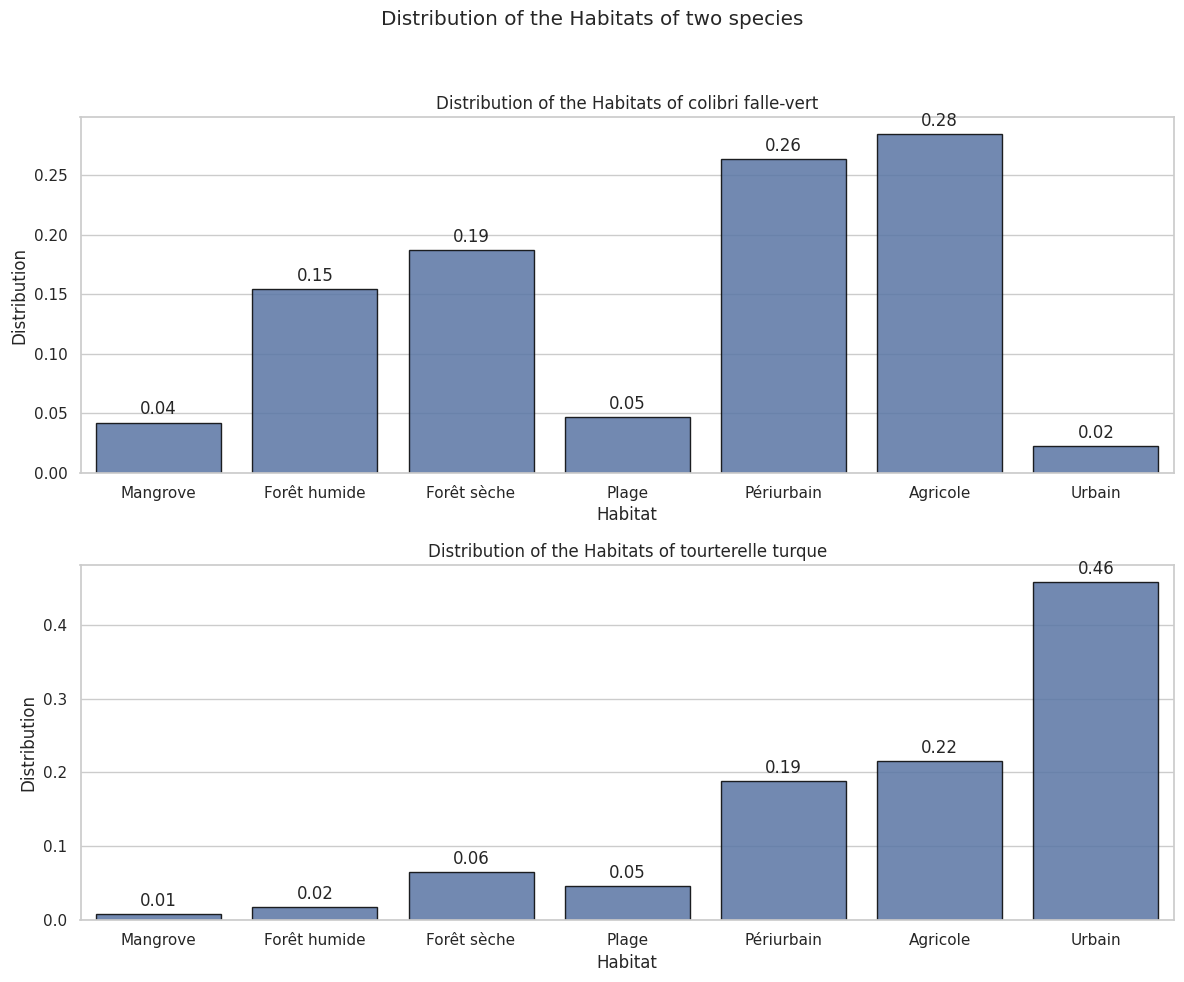

In [42]:

def get_habitat(specie):
    

    df_cut = df_observations[df_observations["clean_espece"] == specie]

    df_cut = df_cut[df_cut["year"] > 2014]

    habitats = pd.Series(0, index = df_sites["Type"].unique())



    for trans, idsite, amount in zip(df_cut["Nom transect"], df_cut["N° point"], df_cut["Amount"]):
        df_sites_cuts = df_sites[df_sites["Transect"] == trans]
        habitat = df_sites_cuts.iloc[int(idsite) - 1]["Type"]
        habitats[habitat] += amount 
    return habitats

habitatMin = get_habitat(minEsp)
habitatMax = get_habitat(maxEsp)

habitatMin = habitatMin / habitatMin.sum()
habitatMax = habitatMax / habitatMax.sum()


fig, axes = plt.subplots(2, 1, figsize =(12, 10))

sns.barplot(x=habitatMin.index, y=habitatMin.values, ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].set_title(f"Distribution of the Habitats of {minEsp}")
axes[0].set_xlabel("Habitat")
axes[0].set_ylabel("Distribution")


sns.barplot(x=habitatMax.index, y=habitatMax.values, ax=axes[1], alpha=0.85, edgecolor="black")
axes[1].set_title(f"Distribution of the Habitats of {maxEsp}")
axes[1].set_xlabel("Habitat")
axes[1].set_ylabel("Distribution")

plt.suptitle("Distribution of the Habitats of two species")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

fig.savefig("figures/distribution_habitats_specie.jpeg")

We notice that the two species have very different habitats compared to each other, and that the distribution of their habitats is pretty diverse.

In [43]:
mask = evolutionSpecies.apply(lambda s: len(s) > 0 and s.iloc[0] > seuil)
new_series = evolutionSpecies[mask]


But now we are going to pick two new species :

- The first is the specie with the biggest variance in the distribution of its habitats.
- The second one is the specie with the lowest variance in the distribution of its habitats.

In clear, we are picking the specie with the most widespread or variable habitats and the specie with the most uniform or consistent habitats.

In [44]:

# Storing the stds
stdHabitats = pd.Series(0.0, new_series.keys())
stdMin , stdMax = np.inf, -np.inf

specieStdMin, specieStdMax = None, None
for specie in new_series.keys():

    hab = get_habitat(specie)
    hab = hab / hab.sum()
    std = hab.std()

    if std > stdMax:
        stdMax = std
        specieStdMax = specie
        habitatMax = hab
        
    if std < stdMin:
        stdMin = std
        specieStdMin = specie
        habitatMin = hab


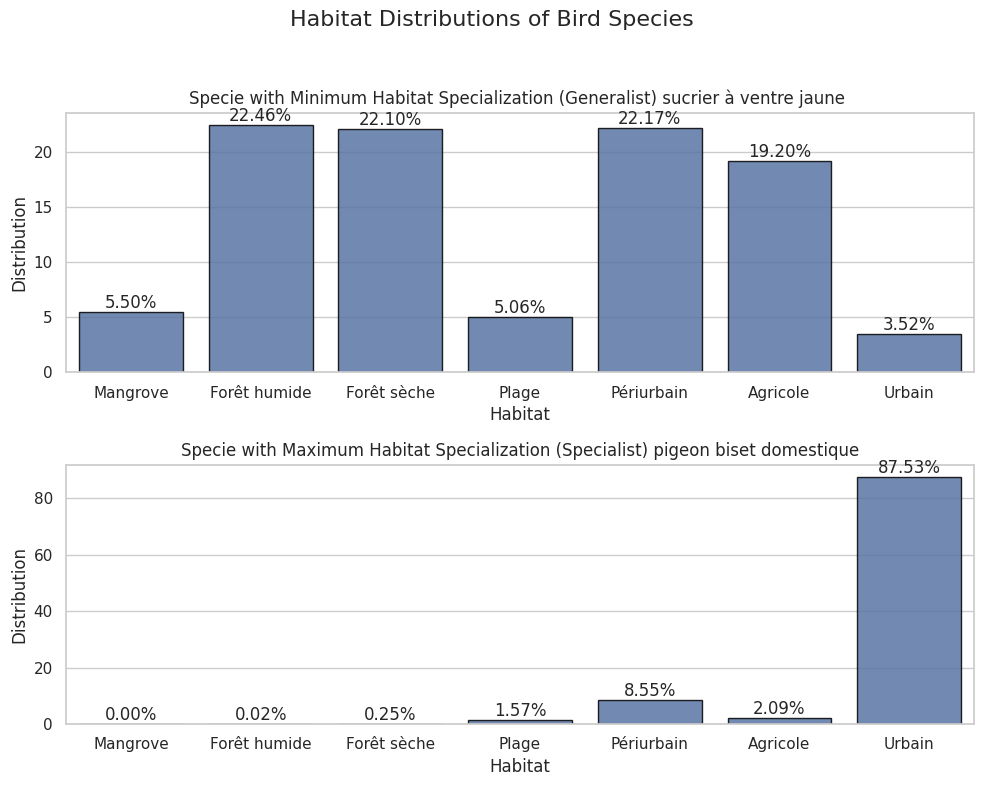

In [45]:
# Create figure with two subplots (vertical)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot habitatMin
sns.barplot(x=habitatMin.index, y = 100 * habitatMin.values, ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].set_title(f"Specie with Minimum Habitat Specialization (Generalist) {specieStdMin} ")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f%%", label_type="edge")
    axes[0].set_xlabel("Habitat")
    axes[0].set_ylabel("Distribution")

# Plot habitatMax
sns.barplot(x=habitatMax.index, y = 100 * habitatMax.values, ax=axes[1], alpha=0.85, edgecolor="black")
axes[1].set_title(f"Specie with Maximum Habitat Specialization (Specialist) {specieStdMax}")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f%%", label_type="edge")
    axes[1].set_xlabel("Habitat")
    axes[1].set_ylabel("Distribution")


# Overall figure title
fig.suptitle("Habitat Distributions of Bird Species", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space at top for suptitle
fig.savefig("figures/distribution_habitat_std_species.jpeg")
plt.show()


We see that the specie with the most uniform habitats is the "sucrier à ventre jaune", that lives almost only in "Forêt humide","Forêt sèche", "Périurbain" and "Agricole".

The specie with least diverse habitats is the pigeon biset domestique, whose habitats are 96% in the city ("Périurbain" and "Urbain").

Now we are going to study the evolution of the population of those two sames species.

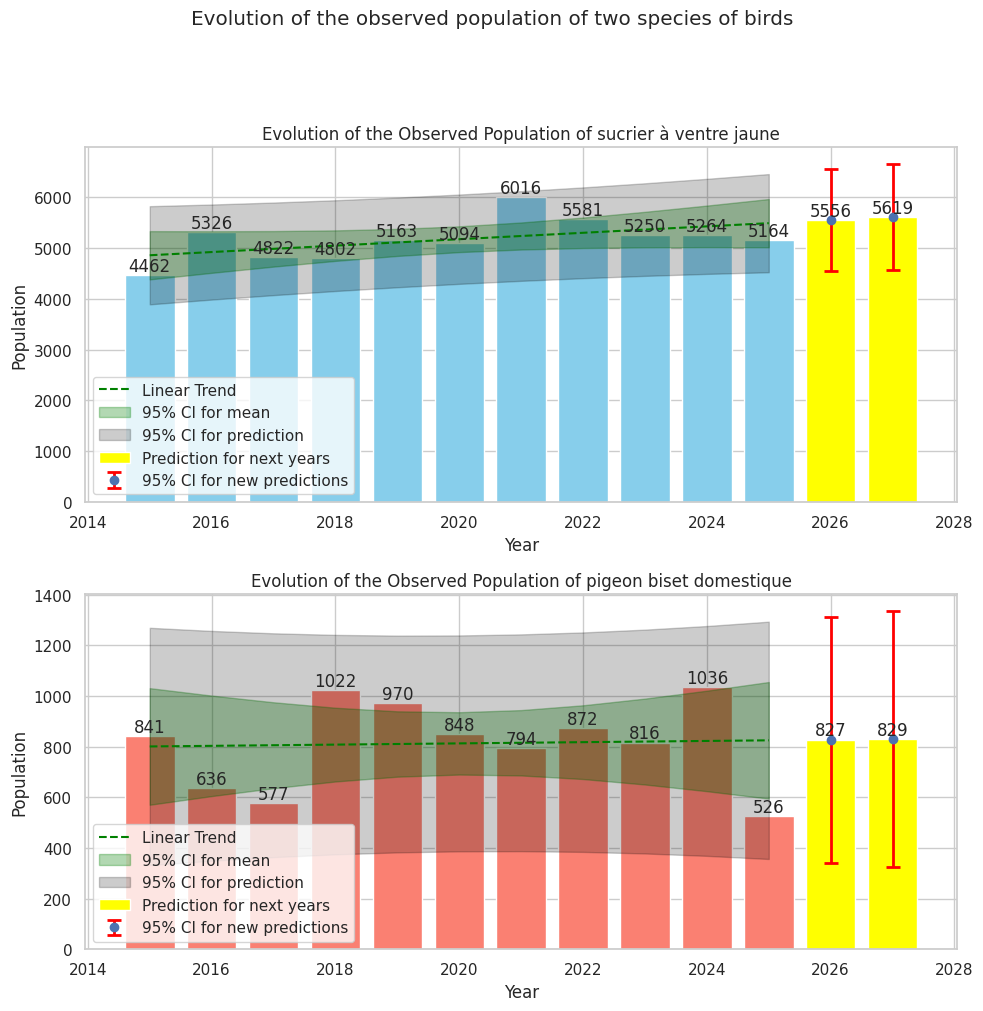

In [ ]:
# Finally let's get interested to the evolution of those species of birds

fig, axes = plt.subplots(2, 1, figsize = (10, 10))

plot_with_trend(axes[0], evolutionSpecies[specieStdMin].keys(), evolutionSpecies[specieStdMin], 'skyblue', f'Evolution of the Observed Population of {specieStdMin}')

# Plot maxEvol
plot_with_trend(axes[1], evolutionSpecies[specieStdMax].keys(), evolutionSpecies[specieStdMax], 'salmon', f'Evolution of the Observed Population of {specieStdMax}')
plt.suptitle("Evolution of the observed population of two species of birds" )
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space at top for suptitle
fig.savefig("figures/evolution_species_std_habitat.jpeg")

We can notice that their population is almost steady (it does not increase that much), so we can deduce the diversity of living places does not really influence on the population.

We can notice also that for the "pigeon biset domestique", the Confidence Interval is huge, so we can deduce that this specie, a linear model is not a good idea.